# Variational Autoencoders
#### Understanding the principle of Variational Autoencoders using the MNIST Dataset
#### *Usage of TF1 without the use of Keras to actively focus on layers of neural network layers and biases.*

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

#### Importing neccesary libraries of Numpy and Matplotlib

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Instructions for updating:
non-resource variables are not supported in the long term


#### Importing the MNIST Dataset of 70000 28x28 Single Channel Images and flattening them into arrays of 28x28 = 784 values, and making their values between 0 and 1.

In [ ]:
from tensorflow.keras.datasets import mnist
(mnist_images_train, mnist_labels_train), (mnist_images_test, mnist_labels_test) = mnist.load_data()
mnist_images_train = mnist_images_train.reshape(60000,784)
mnist_images_train, mnist_images_test = mnist_images_train / 255.0, mnist_images_test / 255.0

11493376/11490434 [==============================] - 0s 0us/step


#### Defining necessary hyperparamaters.

In [ ]:
learning_param = 0.01
epochs = 20000
batch_size = 2048

#### Defining Xavier Initalization which will be used which can help from prevent layer activation outputs from exploding or vanishing during the course of trainig of model.

In [ ]:
def xavier (in_shape):
  val = tf.random.normal(shape = in_shape, stddev = 1.0/(tf.sqrt(in_shape[0]/2.0)))
  return val

![alt text](https://raw.githubusercontent.com/skeydan/whyR2019/master/vae.png)

#### Defining the low dimensional representation, we shall compress the input into a layer with 32 values.

In [ ]:
image_dimension = 784
neural_network_dimension = 32
latent_variable_dimension = 2

#### Defining the weights and biases for the Sampled Latent Vector and the Normal Distribution Layers, with Xavier Initialization

In [ ]:
weight = { "weight_matrix_encoder_hidden": tf.Variable(xavier([image_dimension, neural_network_dimension])),
           "weight_mean_hidden": tf.Variable(xavier([neural_network_dimension, latent_variable_dimension])),
           "weight_std_hidden": tf.Variable(xavier([neural_network_dimension, latent_variable_dimension ])),
           "weight_matrix_decoder_hidden": tf.Variable(xavier([latent_variable_dimension, neural_network_dimension])),
           "weight_decoder": tf.Variable(xavier([neural_network_dimension,image_dimension]))
         }
bias = { "bias_matrix_encoder_hidden": tf.Variable(xavier([neural_network_dimension])),
           "bias_mean_hidden": tf.Variable(xavier([latent_variable_dimension])),
           "bias_std_hidden": tf.Variable(xavier([latent_variable_dimension ])),
           "bias_matrix_decoder_hidden": tf.Variable(xavier([neural_network_dimension])),
           "bias_decoder": tf.Variable(xavier([image_dimension]))
       }

#### Forming layers from the Weight and Biases for Encoder, Decoder and Latent Vector.

In [ ]:
image_X = tf.placeholder(tf.float32, shape=[None, image_dimension])

encoder_layer = tf.add(tf.matmul(image_X, weight['weight_matrix_encoder_hidden']), bias['bias_matrix_encoder_hidden'])
encoder_layer = tf.nn.tanh(encoder_layer)

mean_layer = tf.add(tf.matmul(encoder_layer, weight['weight_mean_hidden']), bias['bias_mean_hidden'])
standard_deviation_layer = tf.add(tf.matmul(encoder_layer, weight['weight_std_hidden']), bias['bias_std_hidden'])

epsilon = tf.random.normal(tf.shape(standard_deviation_layer), dtype = tf.float32, mean = 0, stddev=1.0)
latent_layer = mean_layer + tf.exp(0.5*standard_deviation_layer)*epsilon

decoder_hidden = tf.add(tf.matmul(latent_layer, weight['weight_matrix_decoder_hidden']), bias['bias_matrix_decoder_hidden'])
decoder_hidden = tf.nn.tanh(decoder_hidden)

decoder_output_layer = tf.add(tf.matmul(decoder_hidden, weight['weight_decoder']), bias['bias_decoder'])
decoder_output_layer = tf.nn.sigmoid(decoder_output_layer)

#### In variational autoencoders, the loss function is composed of a data fidelity loss, (that makes the encoding-decoding scheme efficient) and a regularisation term of KL Divergence Loss.

In [ ]:
def loss_function(original_image, reconstructed_image):
  data_fidelity_loss = original_image*tf.log(1e-10 + reconstructed_image) + (1 - original_image)*tf.log(1e-10 + 1 - reconstructed_image)
  data_fidelity_loss = -tf.reduce_sum(data_fidelity_loss, 1)

  KL_div_loss = 1 + standard_deviation_layer - tf.square(mean_layer) - tf.exp(standard_deviation_layer)
  KL_div_loss = -0.5 *tf.reduce_sum(KL_div_loss, 1)

  alpha = 1
  beta = 1
  network_loss = tf.reduce_mean(alpha*data_fidelity_loss + beta*KL_div_loss)
  return (network_loss)

loss_value = loss_function(image_X, decoder_output_layer)
optimizer = tf.train.RMSPropOptimizer(learning_param).minimize(loss_value)

init = tf.global_variables_initializer()

#### Preparing a batch for passing into Neural Network

In [ ]:
def next_batch(num, data, labels):
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle),np.asarray(labels_shuffle)

#### Creating a session for implementing the Graph created and runnning the training.

In [ ]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)


for i in range(epochs):
  x_train = np.reshape(next_batch(batch_size,mnist_images_train,mnist_labels_train)[0], [-1, 784])
  _, loss = sess.run([optimizer, loss_value], feed_dict = {image_X : x_train})
  if i%50 == 0:
    print("Loss after {0} epochs is {1} ".format(i, loss))

Loss after 0 epochs is 614.461669921875 
Loss after 50 epochs is 214.32015991210938 
Loss after 100 epochs is 203.74484252929688 
Loss after 150 epochs is 196.2615509033203 
Loss after 200 epochs is 191.1964569091797 
Loss after 250 epochs is 203.2039794921875 
Loss after 300 epochs is 189.3992462158203 
Loss after 350 epochs is 180.59555053710938 
Loss after 400 epochs is 180.15338134765625 
Loss after 450 epochs is 180.40013122558594 
Loss after 500 epochs is 175.55007934570312 
Loss after 550 epochs is 174.85382080078125 
Loss after 600 epochs is 172.05142211914062 
Loss after 650 epochs is 173.88612365722656 
Loss after 700 epochs is 172.20391845703125 
Loss after 750 epochs is 171.41452026367188 
Loss after 800 epochs is 170.84909057617188 
Loss after 850 epochs is 173.1810302734375 
Loss after 900 epochs is 171.84542846679688 
Loss after 950 epochs is 171.14959716796875 
Loss after 1000 epochs is 166.20904541015625 
Loss after 1050 epochs is 168.70652770996094 
Loss after 1100 ep

#### Preparing the network for Decoder Layers.

In [ ]:
noise_X = tf.placeholder(tf.float32, shape = [None, latent_variable_dimension])

decoder_hidden = tf.add(tf.matmul(noise_X, weight['weight_matrix_decoder_hidden']), bias['bias_matrix_decoder_hidden'])
decoder_hidden = tf.nn.tanh(decoder_hidden)

decoder_output_layer = tf.add(tf.matmul(decoder_hidden, weight['weight_decoder']), bias['bias_decoder'])
decoder_output_layer = tf.nn.sigmoid(decoder_output_layer)

#### Displaying the Map plotted showing the transition from one number to other simulating a 2D normal distribution.

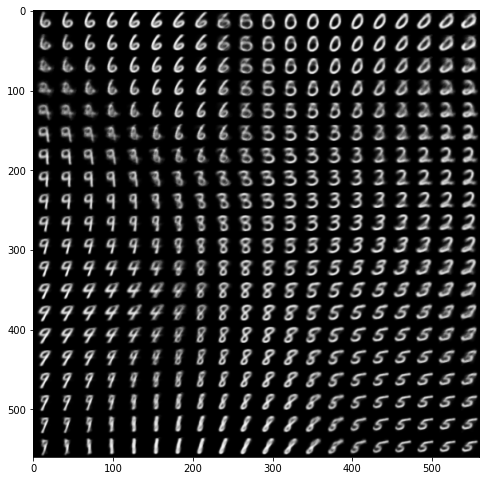

In [ ]:
n = 20
x_limit = np.linspace(-2,2,n)
y_limit = np.linspace(-2,2,n)

empty_image = np.empty((28*n,28*n))

for i,xi in enumerate(x_limit):
  for j,pi in enumerate(y_limit):
    generated_latent_layer = np.array([[xi,pi]]*batch_size)
    #generated_latent_layer = np.random.normal(0, 1, size = [batch_size, latent_variable_dimension])
    generated_image = sess.run(decoder_output_layer, feed_dict = { noise_X: generated_latent_layer })
    empty_image[(n-i-1)*28: (n-i)*28, j*28:(j+1)*28] = generated_image[0].reshape(28,28)

plt.figure(figsize = (8,10))
X,Y = np.meshgrid(x_limit, y_limit)
plt.imshow(empty_image, origin ='upper', cmap ='gray')
plt.grid(False)
plt.show()